In [2]:
##%%
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r"/content/drive/MyDrive/")

Mounted at /content/drive


In [13]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import argparse, progressbar
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
sns.set()

In [3]:
from loader_util.preprocessing import (
    ImageToArrayPreprocessor,
    SimplePreprocessor,
    PatchPreprocessor,
    MeanPreprocessor
)
from loader_util.io import HDF5DatasetGenerator
from loader_util.nn.conv import AlexNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import json
import os

In [11]:
# load the dataset means
mean_filepath = r"/content/drive/MyDrive/Colab Notebooks/ImageDataset/book2/kaggle_dogs_vs_cats/hdf5/output/kaggle_cats_dogs.json"
train_path = r"/content/drive/MyDrive/Colab Notebooks/ImageDataset/book2/kaggle_dogs_vs_cats/hdf5/train.hdf5"
valid_path = r"/content/drive/MyDrive/Colab Notebooks/ImageDataset/book2/kaggle_dogs_vs_cats/hdf5/val.hdf5"
test_path = r"/content/drive/MyDrive/Colab Notebooks/ImageDataset/book2/kaggle_dogs_vs_cats/hdf5/test.hdf5"
model_save_filepath = r"/content/drive/MyDrive/Colab Notebooks/ImageDataset/book2/kaggle_dogs_vs_cats/hdf5/output/alexnet_cats_dogs_model.keras"

In [5]:
# augmentor
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode='nearest')

means = json.loads(open(mean_filepath).read())
print("means: ", means)
# init the preprocessors
sp = SimplePreprocessor(227, 227)
pp = PatchPreprocessor(227, 227)
mp = MeanPreprocessor(rmean=means["r"],
                      gmean=means["g"],
                      bmean=means["b"])
iap = ImageToArrayPreprocessor()


means:  {'r': 125.17531584701538, 'g': 116.08281515960694, 'b': 106.28272320175171}


In [6]:
# init the train and valid data gens
BATCH_SIZE = 128
train_gen = HDF5DatasetGenerator(dbpath=train_path,
                                 batch_size=BATCH_SIZE,
                                 aug=aug,
                                 preprocessors=[pp, mp, iap])
valid_gen = HDF5DatasetGenerator(dbpath=valid_path,
                                 batch_size=BATCH_SIZE,
                                 preprocessors=[sp, mp, iap])

[INFO] initialised HDF5 generator with 20000 data across 2 classes
[INFO] initialised HDF5 generator with 2500 data across 2 classes


In [7]:
# model compilation
print(f"[INFO] compiling the model......")
opt = Adam(learning_rate=0.001)
model = AlexNet.build(height=227, width=227, depth=3, classes=2, reg=0.0002)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


[INFO] compiling the model......


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

In [ ]:
# train the network
H = model.fit(
    train_gen.generator(),
    steps_per_epoch=train_gen.num_images // BATCH_SIZE,
    validation_data=valid_gen.generator(),
    validation_steps=valid_gen.num_images // BATCH_SIZE,
    epochs=75,
    verbose=1)

In [ ]:
# save the model
print(f"[INFO] serialising the model......")
model.save(model_save_filepath, overwrite=True)
train_gen.close()
valid_gen.close()

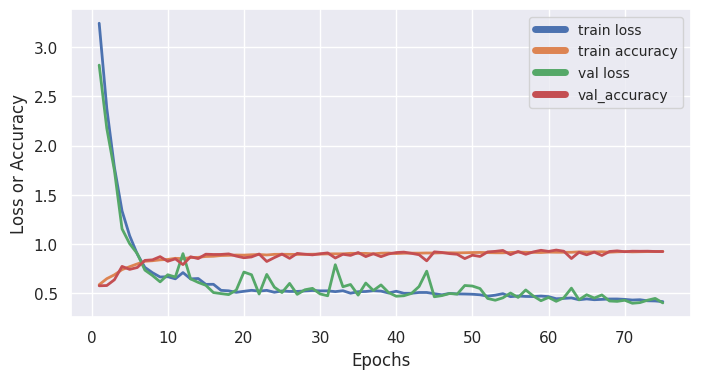

In [17]:
# plot the performance
epochs = range(1, 76)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs, loss, accuracy, val_loss, val_accuracy],
                       columns=['epochs', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=2)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=2)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=2)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=2)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')

# get_texts/get_lines return lists
# plt.setp applies the parameter to elements on that list
# e.g. another way = for line in ax.get_legend().get_lines():
# line.set_linewidth(4)
plt.setp(ax.get_legend().get_texts(), fontsize='10')
plt.setp(ax.get_legend().get_lines(), linewidth='5');